## Simple Neural Network in Pytorch

### Import required libraries

In [1]:
import os
import math
import numpy as np
import time

In [2]:
# libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg','pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

/tmp/ipykernel_69450/3532747965.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg','pdf')


In [3]:
# Import and check torch version
import torch
print("using torch", torch.__version__)

using torch 1.12.0+cu113


In [4]:
# Set seed for reproducability
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  

In [5]:
# `torch.nn` contains classes for building neural networks. This is implemented as modules
# 'torch.nn.functional` are implemented as functions. torch.nn uses functionalities from torch.nn.functional

### Simple Classifier

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# In pytorch, a neural network is built up of modules
# Modules can contain other modules
# A neural network is considered a module in itself

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # calculate the forward pass
        pass

We will train a simple neural network to create a XOR gate. The output of XOR will be true if either one of the inputs is true, otherwise it will be false.
We will add noise to the input to make it harder to learn.  The model we will be creating is visualized below.
* ![Neural Network to create an XOR gate](/Images/xor_nn.png)


In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs,num_hidden,num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs,num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden,num_outputs)

    def forward(self,x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [9]:
model = SimpleClassifier(num_inputs=2,num_hidden=4,num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [10]:
# Print the names and shape of the parameters
for name, param in model.named_parameters():
    print(f"Parameter:{name}, shape: {param.shape}")

Parameter:linear1.weight, shape: torch.Size([4, 2])
Parameter:linear1.bias, shape: torch.Size([4])
Parameter:linear2.weight, shape: torch.Size([1, 4])
Parameter:linear2.bias, shape: torch.Size([1])


Each linear layer will have the weight matrix of shape `[output, input]`, and a bias of shape `[output]`

### The Data 

`torch.utils.data` provides utilites for handling data efficiently.
`data.Dataset` class is the interface to access training/test data.
`data.DataLoader` class is to efficiently prepare batches from dataset

To define a dataset class, we need to specify two functions `__getitem__` and `__len__`. The get-item function will return the ith data point in a dataset. The len function will return the size of the dataset

In [11]:
import torch.utils.data as data

##### The dataset class

In [12]:
class XORDataset(data.Dataset):
    """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1)==1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [13]:
dataset = XORDataset(size=200, std=0.1)
print("size of the dataset:", len(dataset))
print("Data Point 0:", dataset[0])

size of the dataset: 200
Data Point 0: (tensor([0.8675, 0.9484]), tensor(0))


In [14]:
def visualize_samples(data,label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()

    data_0 = data[label==0]
    data_1 = data[label==1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0],data_0[:,1],label="class 0",edgecolor="#333")
    plt.scatter(data_1[:,0],data_1[:,1],label="class 1",edgecolor="#333")
    plt.title("Dataset samples")
    plt.ylabel("$x_2$")
    plt.xlabel("$x_1$")
    plt.legend()

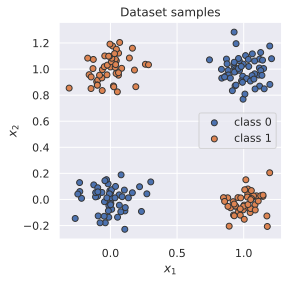

In [15]:
visualize_samples(dataset.data, dataset.label)

#### The dataloader class

`torch.utils.DataLoader` class provides a python iterable over a `dataset` with support for batching, multi-process data loading and many more features.

In [16]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [17]:
# First batch of the data loader
data_inputs, data_labels = next(iter(data_loader))
# The shape of output are [batch_size,dimensions_of_input]
print("Data inputs", data_inputs.shape,"\n", data_inputs)
print("Data labels", data_labels.shape,"\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.1953,  0.2049],
        [-0.1459,  0.8506],
        [-0.1253,  0.1119],
        [ 0.0531, -0.1361],
        [ 0.1345,  0.0127],
        [-0.1449,  0.9395],
        [ 1.0506,  0.9082],
        [ 1.0080,  0.0745]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 0, 0, 1, 0, 1])


### Optimization

#### Loss Modules

* `nn.BCEWithLogitsLoss` - BCE using logits - More stable
* `nn.BCELoss` - BCE using labels (afer applying sigmoid) - Not stable
$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$


In [18]:
loss_module = nn.BCEWithLogitsLoss()

`torch.optim` consists of popular optimizers. `stochastic Gradient Descent` updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting them from the parameters. 

In [19]:
# Input to the optimizer are the parameters of the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

* `optimizer.step()` updates the parameters based on the gradients
* `optimizer.zero_grad()` resets the gradients to zero (otherwise the gradients will be added to the previous ones)

### Training 

In [20]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset,batch_size=128,shuffle=True)

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [22]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
def train_model(model, optimizer,data_loader,loss_module, num_epochs=100):
    # set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            #step 1: Move input data to GPU
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            #step 2: Forward pass
            preds = model(data_inputs)
            # output is [Batch size, 1] but we want [Batch size]
            preds = preds.squeeze(dim=1)  

            #step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            #step 4: Backpropagate
            # Ensure all the gradients are zero
            # otherwise they will be added to the existing ones
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            #step 5: Update the parameters
            optimizer.step()

In [24]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

### Saving a model 

`state_dict` contains the parameters of the model.

In [26]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]], device='cuda:0')), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016], device='cuda:0')), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]], device='cuda:0')), ('linear2.bias', tensor([1.0851], device='cuda:0'))])


In [29]:
torch.save(state_dict,"our_model.tar")

In [30]:
# Load the model
state_dict = torch.load("our_model.tar")

# create a new model and load the state
new_model = SimpleClassifier(num_inputs=2,num_hidden=4,num_outputs=1)
new_model.load_state_dict(state_dict)

# verify if the parameters are same
print("original model\n", model.state_dict())
print("\nnew model\n", new_model.state_dict())

original model
 OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]], device='cuda:0')), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016], device='cuda:0')), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]], device='cuda:0')), ('linear2.bias', tensor([1.0851], device='cuda:0'))])

new model
 OrderedDict([('linear1.weight', tensor([[ 2.2680,  2.2159],
        [-3.4127,  2.4905],
        [-0.2947, -0.1366],
        [-2.2528,  3.2508]])), ('linear1.bias', tensor([-0.4080, -0.9470,  0.7039,  0.8016])), ('linear2.weight', tensor([[ 3.2733,  4.3679,  0.5540, -4.3394]])), ('linear2.bias', tensor([1.0851]))])


### Evaluation 

In [32]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [35]:
def eval_model(model, data_loader):
    # set model to eval mode
    model.eval()
    true_preds, num_preds = 0., 0.

    # No need to calculate gradients for the test data
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            preds_labels = (preds > 0.5).long()

            true_preds += (preds_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    accuracy = true_preds / num_preds
    print(f"Accuracy: {100.0*accuracy:4.2f}%")

In [36]:
eval_model(model,test_data_loader)

Accuracy: 100.00%


### Visualizing classification boundaries

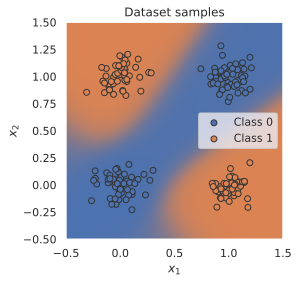

In [37]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

### TensorBoard logging

In [42]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [47]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100,logging_dir = 'runs/our_experiment'):
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    # set the model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            # step 1: Move the data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            # step 2: Forward pass
            preds = model(data_inputs)
            # output is [Batch size, 1] but we want [Batch size]
            preds = preds.squeeze(dim=1)

            # step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # step 4: Backpropagate
            # Ensure all the gradients are zero
            # otherwise they will be added to the existing ones
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # step 5: Update the parameters
            optimizer.step()

            # step 6: Take the running average of the loss
            epoch_loss += loss.item()

    # step 7: Add average loss to TensorBoard
    epoch_loss /= len(data_loader)

    writer.add_scalar('training_loss', epoch_loss, 
                      global_step = epoch + 1)

    # Visualize prediction and add figure to TensorBoard
    # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch

    if (epoch + 1) % 10 == 0:
       fig = visualize_classification(model, val_dataset.data,val_dataset.label)
       writer.add_figure('predictions',fig, global_step = epoch + 1)

    writer.close()


In [53]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
%tensorboard --logdir runs/our_experiment